## 1. Introduction

The goal of this project is to train on a data set that contains daily sales data for different stores and different product families using ETS and Arima as the two time series models to predict two weeks of daily sales for each store and each product family. The performance of the two models are then evaluated and compared using Mean Percentage Error (MPE), Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE), Mean Squared Error (MSE), Mean Absolute Error (MAE) as metrics.

### 2. Data Exploration

First, import the necessary libraries.

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import matplotlib.pyplot as plt
import itertools
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

Load each of the files as a pandas dataframe.

In [7]:
#load each of the files
train=pd.read_csv('train.csv')
stores=pd.read_csv('stores.csv')
holidays=pd.read_csv('holidays_events.csv')
oil=pd.read_csv('oil.csv')
test=pd.read_csv('test.csv')

In [8]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [9]:
num_families=train['family'].nunique()#returns a number of distinct observations
num_stores=train['store_nbr'].nunique()

In [10]:
from itertools import product

families=train['family'].unique()
stores=train['store_nbr'].unique()

train_series_dict={}

train['date']=pd.to_datetime(train['date'], format='%Y-%m-%d')

new_train=train.set_index(['family', 'store_nbr', 'date'])
new_train.loc["GROCERY I"].loc[1]
for family, store in product(families, stores):
    series=new_train.loc[family].loc[store].asfreq('d', method='ffill')#convert TimeSeries to specified frequency
    train_series_dict[(family, store)]=series['sales']
    sales_df=series['sales']#generating a series of daily sales

<br>
Replace zero holiday sales with the mean of sales_df.

In [12]:
sales_df = sales_df.replace(to_replace = 0, value = sales_df.mean())


## 3. ETS Model

Train-Val Date Split (80:20)

Train = '2013-01-01':'2015-12-31'

Val = '2016-01-01':'2017-08-15'

ETS Model

In [16]:
# Model trains on '2013-01-01':'2015-12-31' period
model=ETSModel(sales_df['2013-01-01':'2015-12-31'], trend='add', seasonal='add', seasonal_periods=7)
result=model.fit()

In [17]:
#Model predicts on '2016-01-01':'2017-08-15' period
start='2016-01-01'
end='2017-08-15'

pred_series = result.predict(start=start, end=end)
pred_series

2016-01-01    13.860118
2016-01-02    21.625388
2016-01-03    28.675143
2016-01-04    15.634788
2016-01-05    14.365339
                ...    
2017-08-11    11.076532
2017-08-12    18.841802
2017-08-13    25.891557
2017-08-14    12.851202
2017-08-15    11.581753
Freq: D, Length: 593, dtype: float64

<br>
Actual data on validation period

In [19]:
observations=sales_df['2016-01-01':'2017-08-15']

<br>
Correlation Coef

In [21]:
corr = np.corrcoef(pred_series, observations)
corr

array([[1.        , 0.49461076],
       [0.49461076, 1.        ]])

<br>
Calculations of Metrics

In [23]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
mpe = np.round(np.mean((observations- pred_series)/observations),3)
mae = np.round(mean_absolute_error(observations, pred_series),3)
mape = np.round(MAPE(observations, pred_series),3)
mse = np.round(mean_squared_error(observations, pred_series, squared=False),3)
rmse = np.round(mse**0.5,3)
mae = np.round(mean_absolute_error(observations, pred_series),3)
rmsle = np.round(mean_squared_log_error(observations, pred_series),3)

print(f" MPE: {mpe}")
print(f" MAPE: {mape}")
print(f" MAE: {mae}")
print(f" MSE: {mse}")
print(f" RMSE: {rmse}")
print(f" RMSLE: {rmsle}")

 MPE: -0.138
 MAPE: 0.426
 MAE: 6.001
 MSE: 7.973
 RMSE: 2.824
 RMSLE: 0.19


<br>
Time Series Plot for Validation Period

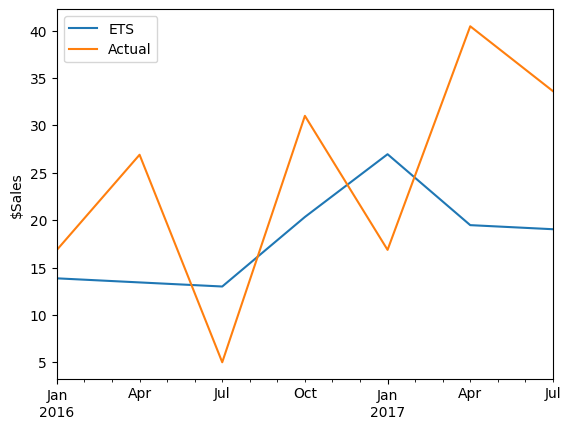

In [25]:
index = pd.date_range("2016-01-01", "2017-08-15", freq="3MS") 
observations = pd.Series(observations, index=index)
pred_series = pd.Series(pred_series, index=index)

plt.ylabel("$Sales") 
pred_series.plot(label='ETS')
observations.plot(label='Actual')
plt.legend()

<a name='submission'></a>
## 4. ETS Submission 

In [27]:
ets_results_dict={}

for key, series in train_series_dict.items():
    model=ETSModel(endog=series[:'2017-08-01'], trend='add', seasonal='add', seasonal_periods=7)
    result=model.fit()
    ets_results_dict[key]=result


In [28]:
ets_pred={}
start='2017-08-16'
end='2017-08-31'

for key, model in ets_results_dict.items():
    pred_series=model.predict(start=start, end=end)
    ets_pred[key]=pred_series

Add appropriate 'Id'

In [30]:
sample_submission = pd.read_csv('sample_submission.csv')
predictions_df=pd.concat(objs=ets_pred)
predictions_df=predictions_df.to_frame(name='sales')
#predictions_df=predictions_df.reset_index()
#predictions_df=predictions_df.rename(mapper={'level_0': 'family', 'level_1': 'store_nbr', 'level_2': 'date'}, axis=1)
predictions_df.index.rename(['family', 'store_nbr', 'date'], inplace=True)

test['date']=pd.to_datetime(test['date'], format='%Y-%m-%d')

submission_df=test.join(other=predictions_df ,on=['family', 'store_nbr', 'date'],how='left')
display(submission_df)
submission_df.drop(axis=1, labels=['onpromotion', 'date', 'family', 'store_nbr'], inplace=True)
submission_df.set_index('id', inplace=True)
display(submission_df)
submission_df.to_csv('submission.csv')

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,4.776623
1,3000889,2017-08-16,1,BABY CARE,0,0.000000
2,3000890,2017-08-16,1,BEAUTY,2,3.497976
3,3000891,2017-08-16,1,BEVERAGES,20,2549.828607
4,3000892,2017-08-16,1,BOOKS,0,0.218159
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,367.098945
28508,3029396,2017-08-31,9,PREPARED FOODS,0,84.824797
28509,3029397,2017-08-31,9,PRODUCE,1,1249.904615
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,112.232266


,sales
id,
3000888,4.776623
3000889,0.000000
3000890,3.497976
3000891,2549.828607
3000892,0.218159
...,...
3029395,367.098945
3029396,84.824797
3029397,1249.904615


<a name='references'></a>
## 5. ARIMA MODEL

Adfuller Test for Stationary

In [33]:
#for key, series in train_series_dict.items():
adftest = adfuller(sales_df, maxlag=10, regression='c')

In [34]:
print("p-value of adfuller test: ", adftest[1])#sales_df is a stationary series

p-value of adfuller test:  1.4668241848275784e-12


<br>
Model trains on '2013-01-01':'2015-12-31' period

In [36]:
model=ARIMA(sales_df['2013-01-01':'2015-12-31'], order=(1,0,1))
#model=ARIMA(endog=sales_df[:'2017-08-01'], order=(5,1,0))#5,1,0 -  1,0,1 
result=model.fit()

<br>
Model validates on '2016-01-01':'2017-08-15' period

In [38]:
#arima_pred={}
start='2016-01-01'
end='2017-08-15'

#for key, model in arima_results_dict.items():
#pred_series=model.predict(start=start, end=end)
pred_series=result.predict(start=start, end=end)
pred_series

2016-01-01    16.813569
2016-01-02    16.813654
2016-01-03    16.813738
2016-01-04    16.813820
2016-01-05    16.813900
                ...    
2017-08-11    16.818037
2017-08-12    16.818037
2017-08-13    16.818037
2017-08-14    16.818037
2017-08-15    16.818037
Freq: D, Name: predicted_mean, Length: 593, dtype: float64

In [39]:
observations=sales_df['2016-01-01':'2017-08-15']

In [40]:
corr = np.corrcoef(pred_series, observations)
corr

array([[ 1.        , -0.01706291],
       [-0.01706291,  1.        ]])

In [41]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
mpe = np.round(np.mean((observations- pred_series)/observations),3)
mae = np.round(mean_absolute_error(observations, pred_series),3)
mape = np.round(MAPE(observations, pred_series),3)
mse = np.round(mean_squared_error(observations, pred_series, squared=False),3)
rmse = np.round(mse**0.5,3)
mae = np.round(mean_absolute_error(observations, pred_series),3)
rmsle = np.round(mean_squared_log_error(observations, pred_series),3)

print(f" MPE: {mpe}")
print(f" MAPE: {mape}")
print(f" MAE: {mae}")
print(f" MSE: {mse}")
print(f" RMSE: {rmse}")
print(f" RMSLE: {rmsle}")

 MPE: -0.264
 MAPE: 0.515
 MAE: 6.737
 MSE: 9.032
 RMSE: 3.005
 RMSLE: 0.242


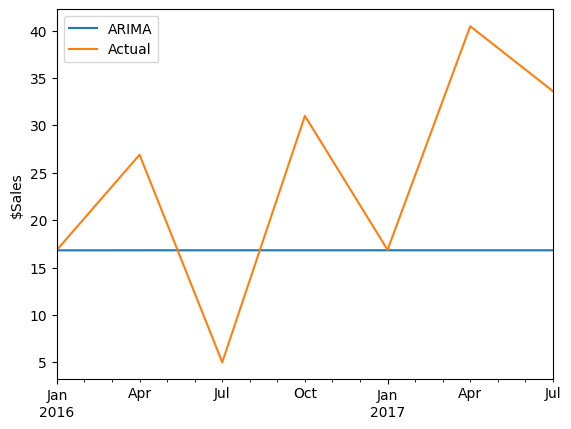

In [42]:
index = pd.date_range("2016-01-01", "2017-08-15", freq="3MS") 
observations = pd.Series(observations, index=index)
pred_series = pd.Series(pred_series, index=index)

plt.ylabel("$Sales") 
pred_series.plot(label='ARIMA')
observations.plot(label='Actual')
plt.legend()

## 5. ARIMA SUBMISSION

In [44]:
arima_results_dict={}

for key, series in train_series_dict.items():
    model1=ARIMA(endog=series[:'2017-08-01'], order=(1,0,1))
    result=model1.fit()
    arima_results_dict[key]=result

In [45]:
arima_pred={}
start='2017-08-16'
end='2017-08-31'

for key, model in arima_results_dict.items():
    pred_series=model.predict(start=start, end=end)
    arima_pred[key]=pred_series

In [46]:
sample_submission = pd.read_csv('sample_submission.csv')

predictions_df=pd.concat(objs=arima_pred)
predictions_df=predictions_df.to_frame(name='sales')
#predictions_df=predictions_df.reset_index()
#predictions_df=predictions_df.rename(mapper={'level_0': 'family', 'level_1': 'store_nbr', 'level_2': 'date'}, axis=1)
predictions_df.index.rename(['family', 'store_nbr', 'date'], inplace=True)

test['date']=pd.to_datetime(test['date'], format='%Y-%m-%d')

submission_df=test.join(other=predictions_df ,on=['family', 'store_nbr', 'date'],how='left')
display(submission_df)
submission_df.drop(axis=1, labels=['onpromotion', 'date', 'family', 'store_nbr'], inplace=True)
submission_df.set_index('id', inplace=True)
display(submission_df)
submission_df.to_csv('submission.csv')

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,4.317901
1,3000889,2017-08-16,1,BABY CARE,0,-0.000005
2,3000890,2017-08-16,1,BEAUTY,2,2.891516
3,3000891,2017-08-16,1,BEVERAGES,20,2084.565422
4,3000892,2017-08-16,1,BOOKS,0,0.157178
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,484.981640
28508,3029396,2017-08-31,9,PREPARED FOODS,0,88.466082
28509,3029397,2017-08-31,9,PRODUCE,1,1552.149190
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,9.696351


,sales
id,
3000888,4.317901
3000889,-0.000005
3000890,2.891516
3000891,2084.565422
3000892,0.157178
...,...
3029395,484.981640
3029396,88.466082
3029397,1552.149190


CONCLUSION
A series of daily sales has been extracted from the data set and used by both ETS and ARIMA models to predict daily sale for the time period from 2017-08-16 to 2016-08-31. This series was tested by the Adfuller test with zero p-value therefore a stationary series. The performance of the two models are then compared in the table below.

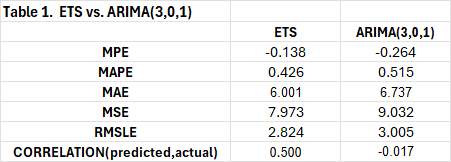![image.png].

The ETS model seems to be much better with the smaller MPE, MAPE, MAE, MSE, and RMSLE but larger correlation between actual and forecast at 0.500.

The ARIMA(3,0,1) for some reason not well understood has worse performance metrics as well as a negative correlation coefficient of -0.017. Further study is needed to refine this model.
